In [45]:
!pip install torchvision==1.11.0

ERROR: Could not find a version that satisfies the requirement torchvision==1.11.0 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.5.0, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.11.0, 0.11.1, 0.11.2, 0.11.3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1)
ERROR: No matching distribution found for torchvision==1.11.0


In [1]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

<ipython-input-1-309099f3fc35>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [14]:
data = pd.read_csv('train.csv')
data.head()

,class_id,image
0,1221,3kVLfN1tTupzPhFgWY0yeOnqoD6RwG57HlSMvBK4.jpg
1,1209,p5FeqKS7BHknQM4OvbzZs60giLthaCW83VGDx1Y9.jpg
2,865,3GHsrhop0FJ58EBjLDgQed2NvI4UK1ybZRAuTl6n.jpg
3,1222,DqoLbEG8A9lJCaR7ucOdiP05rXxyjg4WwMSh2VFs.jpg
4,542,TV1zBo5gLt34i76pAFya90HuJWNjkZSCwbKDevnO.jpg


In [15]:
data[data['image'] == "moBOxq9vVZ4cThRlLai5gpeKu1M6EIbwYS3XnGtd.jpg"]

,class_id,image
39394,4276,moBOxq9vVZ4cThRlLai5gpeKu1M6EIbwYS3XnGtd.jpg


In [3]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# папка с данными. Если запускаете в колабе, нужно скопировать данные к себе в директорию и примонтировать диск. Если запускаете локально -- просто скачайте данные
data_dir = './train_test'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [18]:
print(dataset_sizes)

{'train': 36249, 'val': 11042}


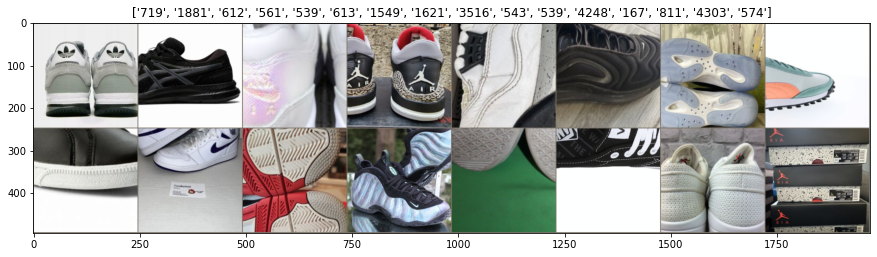

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
try:
    for data in tqdm(dataloaders['train'], leave=False, desc=f"train iter:"):
        inputs, labels = data
except ValueError:
    print(ValueError)

UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\torch\utils\data\_utils\worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\User\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\User\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\User\anaconda3\lib\site-packages\torchvision\datasets\folder.py", line 137, in __getitem__
    sample = self.loader(path)
  File "C:\Users\User\anaconda3\lib\site-packages\torchvision\datasets\folder.py", line 173, in default_loader
    return pil_loader(path)
  File "C:\Users\User\anaconda3\lib\site-packages\torchvision\datasets\folder.py", line 155, in pil_loader
    img = Image.open(f)
  File "C:\Users\User\anaconda3\lib\site-packages\PIL\Image.py", line 3008, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='./train_test\\train\\4276\\moBOxq9vVZ4cThRlLai5gpeKu1M6EIbwYS3XnGtd.jpg'>


In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                try:
                    # получаем картинки и метки
                    inputs, labels = data

                    # оборачиваем в переменные
                    if use_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    else:
                        inputs, labels = inputs, labels

                    # инициализируем градиенты параметров
                    if phase=="train":
                        optimizer.zero_grad()

                    # forward pass
                    if phase == "eval":
                        with torch.no_grad():
                            outputs = model(inputs)
                    else:
                        outputs = model(inputs)
                    preds = torch.argmax(outputs, -1)
                    loss = criterion(outputs, labels)

                    # backward pass + оптимизируем только если это стадия обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # статистика
                    running_loss += loss.item()
                    running_corrects += int(torch.sum(preds == labels.data))
                except Exception:
                    pass

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [8]:
# Ваш код здесь
model_extractor = models.vgg16(pretrained=True)

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 4396)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=5)


Training complete in 52m 41s
Best val Acc: 0.347645


In [27]:
torch.save(model_extractor.state_dict(), 'VGG16.pth')

In [9]:
model_extractor.load_state_dict(torch.load('VGG16.pth'))

<All keys matched successfully>

In [29]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

NameError: name 'evaluate' is not defined

# Тестирование

In [46]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

use_gpu = torch.cuda.is_available()

In [23]:
test = pd.read_csv('test.csv')
test.head()

,class_id,image
0,NaN,mwiNS62kZXUEJARdf3rxCpI0VztLO1B7guKTDGMj.jpg
1,NaN,Dvtu5QLrVFq0JxjlcgmK94n3SC68iAphHXoBfzYM.jpg
2,NaN,mldYZ9OiXh5P0ERHNcKLp78SbMtfkBx2rwJeszoa.jpg
3,NaN,tZaCF4XK2hPLTlW8YRdAnMD5mfSxzBujwVpUJ7b0.jpg
4,NaN,73gEZNzIV9SLcf14wkrTYUoHJOMuDetsvihP0mAq.jpg


In [47]:
model_extractor = models.efficientnet_b1(pretrained=True)
model_extractor.load_state_dict(torch.load('efnet_b1.pth'))

AttributeError: module 'torchvision.models' has no attribute 'efficientnet_b1'

In [ ]:
import os
os.remove('./images/BunpXaDiFChjE79yHgcNz5kTMJZwlYQRmUIteK6A.jpg')

In [10]:
classes_id = []

transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(244),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
SIZE_DELETE = 1000
PATH = './images/images'
for index, row in tqdm(test.iterrows(),total=test.shape[0]):
    image_name = row['image']
#     print(os.path.getsize(f'images/images/{image_name}'))
    if os.path.exists(f'{PATH}{image_name}') and (os.path.getsize(f'{PATH}{image_name}') > SIZE_DELETE):
        image = Image.open(f'{PATH}{image_name}').convert('RGB')
        image = transform(image).unsqueeze(0)
        image = image.cuda()
    #     print(image_name)

        output = model_extractor(image)
        classes_id.append(torch.argmax(output, -1).item())
    else:
        classes_id.append(775)

In [12]:
test['class_id'] = classes_id

In [14]:
test.to_csv('submit.csv', index=False)

# Сабмит смотрю

In [3]:
sub = pd.read_csv('submit.csv')
sub.head()

,class_id,image
0,3321,mwiNS62kZXUEJARdf3rxCpI0VztLO1B7guKTDGMj.jpg
1,3631,Dvtu5QLrVFq0JxjlcgmK94n3SC68iAphHXoBfzYM.jpg
2,2155,mldYZ9OiXh5P0ERHNcKLp78SbMtfkBx2rwJeszoa.jpg
3,312,tZaCF4XK2hPLTlW8YRdAnMD5mfSxzBujwVpUJ7b0.jpg
4,3559,73gEZNzIV9SLcf14wkrTYUoHJOMuDetsvihP0mAq.jpg


In [14]:
class_count = sub.groupby(['class_id']).count()

In [27]:
class_count.sort_values('image')

,image
class_id,
1244,1
3147,1
1215,1
1217,1
1225,1
...,...
3053,569
3559,681
3642,853


In [37]:
class_count[class_count['image'] > 500]

,image
class_id,
3053,569
3472,1235
3559,681
3631,971
3642,853
